In [42]:
import matplotlib.pyplot as plt
import pickle

import utilities
import os.path



In [50]:
def plothillclimb(file, baselines=None):
    print(file)
    if os.path.isdir(file):
        files = [os.path.join(file, f) for f in os.listdir(file)]
        baseline = next((f for f in files if 'bs' in f and "pkl" in f), None)
        for f in files:
            if "hc" in f and "pkl" in f:
                plothillclimb(f, baseline)
        return
    if "pkl" not in file:
        file += ".pkl"
    if "out" not in file:
        file = "out/" + file
    with open(file,'rb') as savefile:
        save = pickle.load(savefile)
    print(save["args"])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,8))
    accs = [log['validation']['accuracy'][-1] for (key, log) in save.items() if key != "args"]
    maxacc = max(accs)
    minacc = min(accs)
    epochsteps = [log['epochsteps'][-1] for (key, log) in save.items() if key != "args"]
    print(minacc, maxacc)
    #ax1.set_yscale('log')
    labelcount = 0
    colors = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9", ]
    for (i, (uuid, log)) in enumerate(sorted([(key, log) for (key, log) in save.items() if key != "args"], key=lambda x: x[1]['validation']['accuracy'][-1], reverse=True)):
        if i > 1000:
            break
        if len(log['epochsteps']) > 5 and log['epochsteps'][0] == log['epochsteps'][5]:
            for i in range(5):
                log['epochsteps'][i] -= 1
            for i in range(190):
                log['trainsteps'][i] -= 1
        alpha = ((log['validation']['accuracy'][-1]-minacc)/(maxacc-minacc))**8
        #if i < 5 and ("test" in save["args"] and save["args"]["pareto"]):
        if "test" in log and labelcount < 5:
            if type(log["ghistory"][-1][-1]) is tuple:
                label = str(log["ghistory"][-1])+" - "
            else:
                label = str(log["ghistory"][-6:])+" - "
            if "test" in log:
                label += str(log['test'])[:6]
            else:
                label += "(val) " + str(log['validation']['accuracy'][-1])[:6]
            label = label.replace('(0, 0)', '$C_1$')
            label = label.replace('(0, 1)', '$C_2$')
            label = label.replace('(0, 2)', '$C_4$')
            label = label.replace('(0, 3)', '$C_8$')
            label = label.replace('(0, 4)', '$C_{16}$')
            label = label.replace('(1, 0)', '$D_1$')
            label = label.replace('(1, 1)', '$D_2$')
            label = label.replace('(1, 2)', '$D_4$')
            label = label.replace('(1, 3)', '$D_8$')
            label = label.replace('(1, 4)', '$D_{16}$')
            color = colors[labelcount]
            labelcount += 1
            print(len(log['epochsteps']), log['validation']['accuracy'][-1], log["ghistory"][0])
        else:
            label = None
            #gets next color from cycler
            color = next(ax1._get_lines.prop_cycler)['color']
        #if "distances" in log:
        #    print(label, len(log["distances"]), len(log['epochsteps']), len(log['validation']['accuracy']))
        if alpha > 0.0:
            #ax1.plot(log['trainsteps'], log['train']['batchloss'], alpha=alpha, linewidth = alpha)
            ax1.plot(log['epochsteps'], log['distances'], alpha=alpha, linewidth = alpha, color=color)
            ax2.plot(log['epochsteps'], log['validation']['accuracy'], alpha=alpha, linewidth = alpha, label=label, color=color)
            ax3.plot(log['epochsteps'], log['validation']['accuracy'], alpha=alpha, linewidth = alpha, color=color)
    ax1.set_title('Distance to $D_4$ projection')
    ax2.set_title('Validation accuracy')
    ax3.set_title('Validation accuracy (zoomed in)')
    ax1.set_xlabel('Generations')
    ax2.set_xlabel('Generations')
    ax3.set_xlabel('Generations')
    ax1.set_ylabel('Distance')
    ax2.set_ylabel('Accuracy')
    ax3.set_ylabel('Accuracy')
    print(save["args"].keys())
    if save["args"]["pareto"]:  
        plt.suptitle("Pareto-front selection")
    else:
        plt.suptitle("Top-5 selection")
    if baselines is not None:
        if "pkl" not in baselines:
            baselines += ".pkl"
        if "out" not in baselines:
            baselines = "out/" + baselines
        with open(baselines,'rb') as savefile:
            save = pickle.load(savefile)
        accs = [log['validation']['accuracy'][-1] for (key, log) in save.items() if key != "args"]
        colors = ["#E69F00", "#F0E442", "#0072B2", "#A52E00", "#009E73", "#CC79A7"]
        for (i, (uuid, log)) in enumerate([(key, log) for (key, log) in save.items() if key != "args"]):
            if log["epochsteps"][0] > 0:
                fix = log["epochsteps"][0]
                for i in range(len(log["epochsteps"])):
                    log['epochsteps'][i] -= fix
                for i in range(len(log["trainsteps"])):
                    log['trainsteps'][i] -= fix
            if 'name' in log and len(log['name']) > 0:
                label = "Baseline: " + log['name'] + " "
            else:
                # if type(log["ghistory"][-1][-1]) is tuple:
                #     label = "Baseline: "+str(log["ghistory"][-1])+" - "
                # else:
                #     label = "Baseline: "+str(log["ghistory"][-6:])+" - "
                label = "Baseline: "
                if i == 3:
                    label += "C1 (prior: D4) "
                elif i == 4:
                    label += "C4 (prior: D4) "
                elif i == 5:
                    label += "C1 (prior: C4) "
            if "test" in log:
                label += str(log['test'])[:6]
            else:
                label += "(val) " + str(log['validation']['accuracy'][-1])[:6]
            label = label.replace('(0, 0)', '$C_1$')
            label = label.replace('C1', '$C_1$')
            label = label.replace('(0, 1)', '$C_2$')
            label = label.replace('(0, 2)', '$C_4$')
            label = label.replace('C4', '$C_4$')
            label = label.replace('(0, 3)', '$C_8$')
            label = label.replace('(0, 4)', '$C_{16}$')
            label = label.replace('(1, 0)', '$D_1$')
            label = label.replace('(1, 1)', '$D_2$')
            label = label.replace('(1, 2)', '$D_4$')
            label = label.replace('D4', '$D_4$')
            label = label.replace('(1, 3)', '$D_8$')
            label = label.replace('(1, 4)', '$D_{16}$')
            #if "distances" in log:
            #    print(label, len(log["distances"]), len(log['epochsteps']), len(log['validation']['accuracy']))
            #ax1.plot(log['trainsteps'], log['train']['batchloss'], linestyle='dashed')
            ax1.plot(log['epochsteps'], log['distances'], linestyle='dashed', color=colors[i])
            ax2.plot(log['epochsteps'], log['validation']['accuracy'], label=label, linestyle='dashed', color=colors[i])
            ax3.plot(log['epochsteps'], log['validation']['accuracy'], linestyle='dashed', color=colors[i])
    ax3.set_ylim(0.97*maxacc, 1.003*maxacc)
    ax1.set_ylim(-0.1, 11)
    ax2.legend(loc='lower left')
    plt.savefig(file[:-2]+'ng')


out/lisagpu/ermnas_2022-09-23.11:31:46_galaxy10_lr0.03_ep0.5
out/lisagpu/ermnas_2022-09-23.11:31:46_galaxy10_lr0.03_ep0.5/logshc_10034792.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.03, 'popsize': 5, 'baselines': False, 'data': PosixPath('..'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'skip': False, 'pareto': True, 'pareto2': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-23.11:31:46_galaxy10_lr0.03_ep0.5', 'name': '10034792', 'task': 'galaxy10', 'train_vanilla': False, 'val_vanilla': False, 'test_vanilla': False}
0.06171679124236107 0.17543859779834747
dict_keys(['epochs', 'generations', 'lr', 'popsize', 'baselines', 'data', 'd16', 'c4', 'seed', 'dea', 'skip', 'pareto', 'pareto2', 'unique', 'test', 'folder', 'name', 'task', 'train_vanilla', 'val_vanilla', 'test_vanilla'])
out/lisagpu/ermnas_2022-09-23.11:31:46_galaxy10_lr0.03_ep0.5/logshc_10034791.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.03, 'popsize': 5, 'baselines': False, 'data': PosixPath('..')

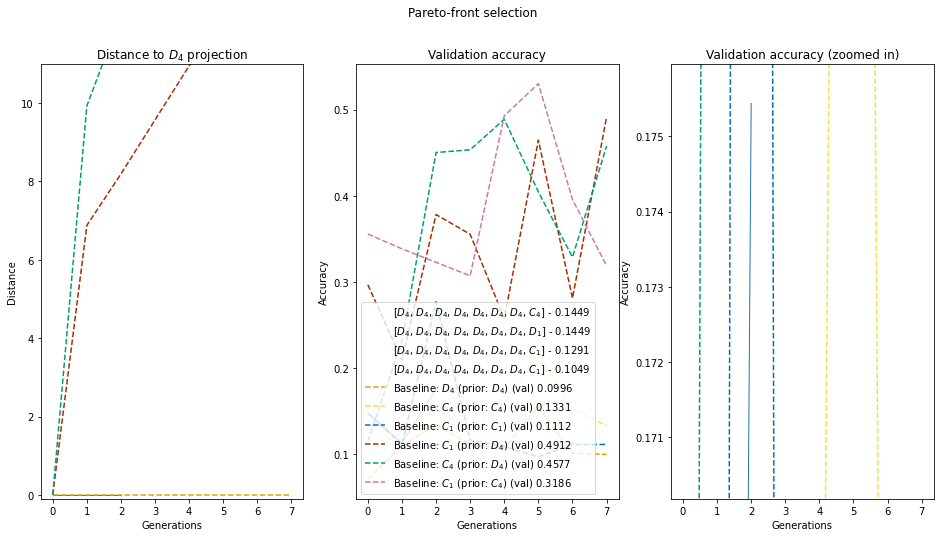

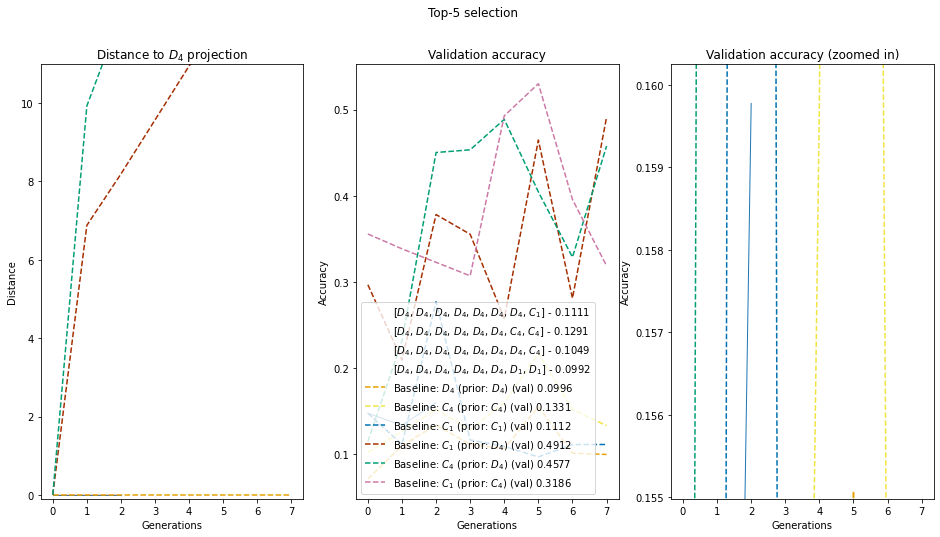

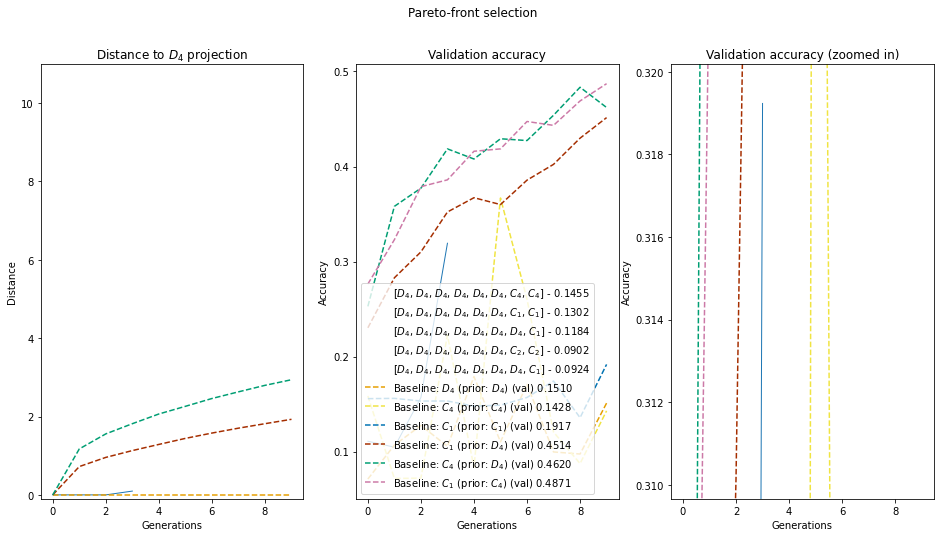

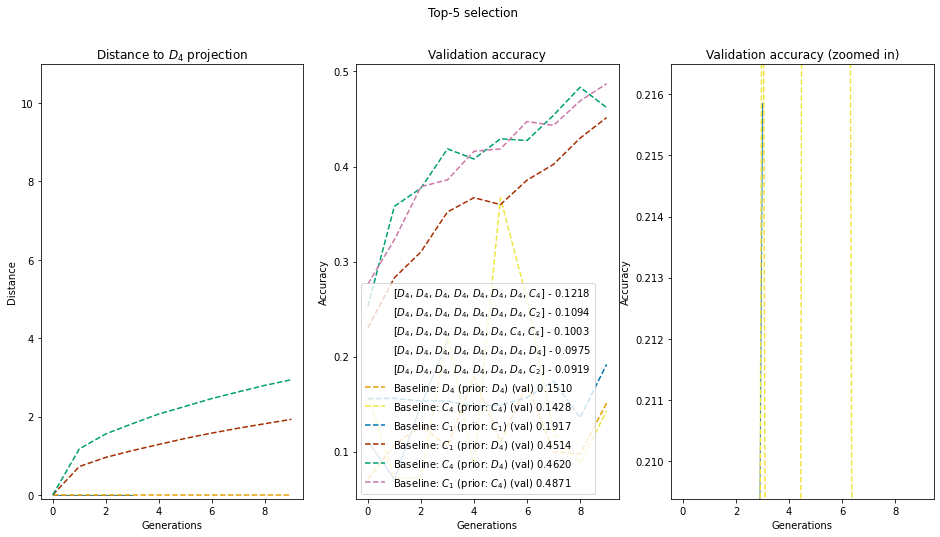

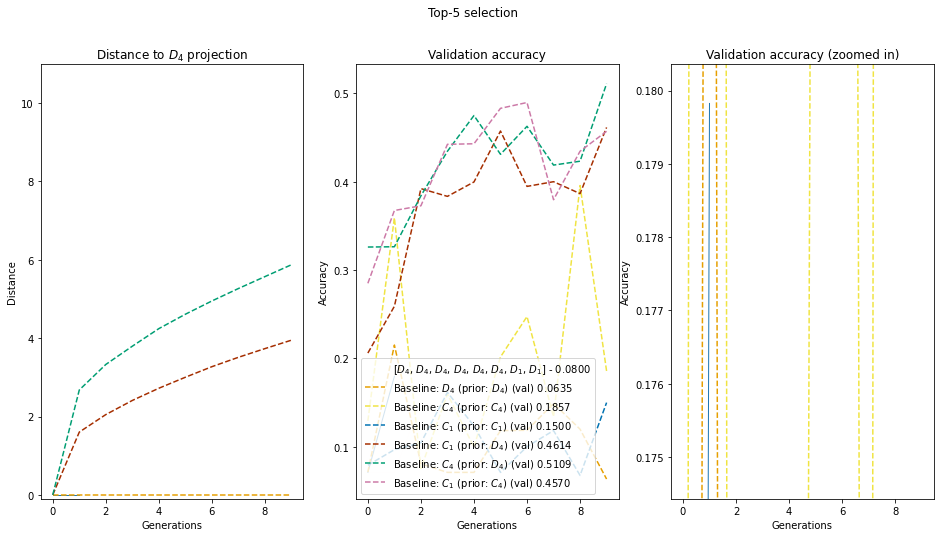

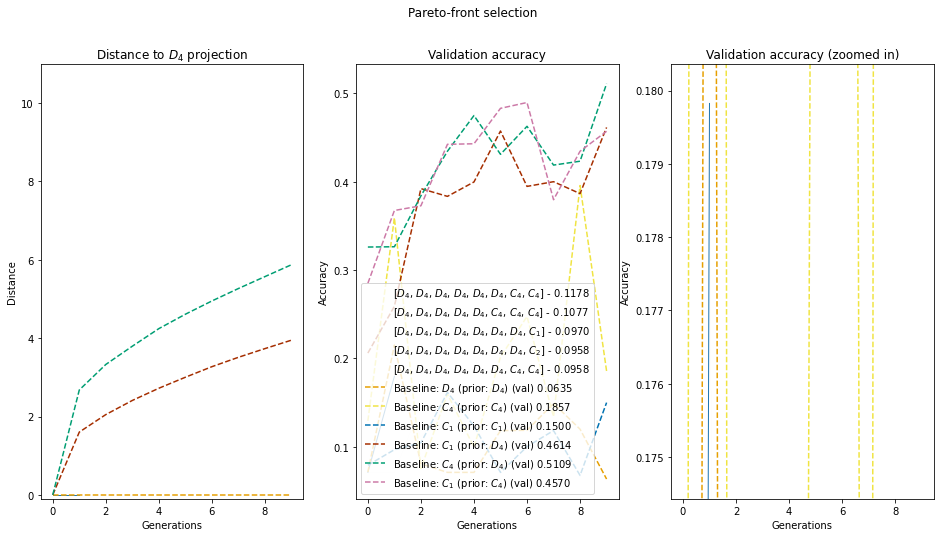

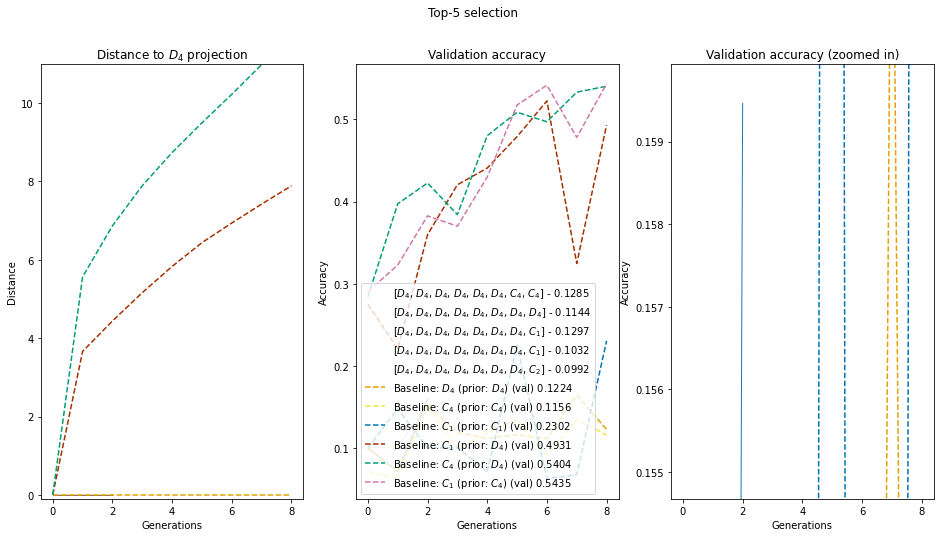

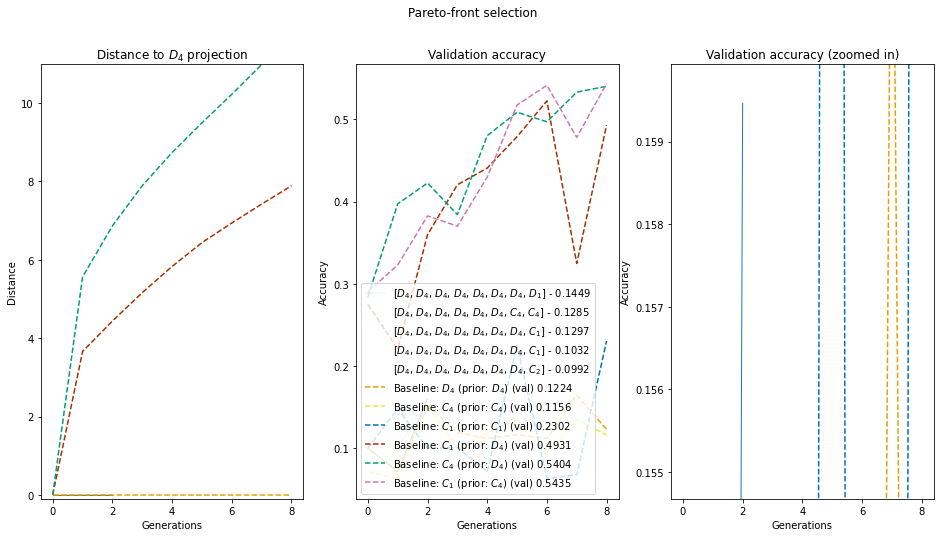

In [29]:
plothillclimb("out/lisagpu/ermnas_2022-09-23.11:31:46_galaxy10_lr0.03_ep0.5")
plothillclimb("out/lisagpu/ermnas_2022-09-23.11:31:45_galaxy10_lr0.001_ep0.5")
plothillclimb("out/lisagpu/ermnas_2022-09-23.11:31:45_galaxy10_lr0.003_ep0.5")
plothillclimb("out/lisagpu/ermnas_2022-09-23.11:31:46_galaxy10_lr0.01_ep0.5")

out/lisagpu/ermnas_2022-09-22.18:49:11_galaxy10small_lr0.1_ep0.5
out/lisagpu/ermnas_2022-09-22.18:49:11_galaxy10small_lr0.1_ep0.5/logshc_10033788.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 5, 'baselines': False, 'data': PosixPath('..'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'skip': False, 'pareto': False, 'pareto2': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-22.18:49:11_galaxy10small_lr0.1_ep0.5', 'name': '10033788', 'task': 'galaxy10small', 'train_vanilla': False, 'val_vanilla': False, 'test_vanilla': False}
0.06171679124236107 0.7026942372322083
dict_keys(['epochs', 'generations', 'lr', 'popsize', 'baselines', 'data', 'd16', 'c4', 'seed', 'dea', 'skip', 'pareto', 'pareto2', 'unique', 'test', 'folder', 'name', 'task', 'train_vanilla', 'val_vanilla', 'test_vanilla'])
out/lisagpu/ermnas_2022-09-22.18:49:11_galaxy10small_lr0.1_ep0.5/logshc_10033789.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 5, 'baselines': False, 'dat

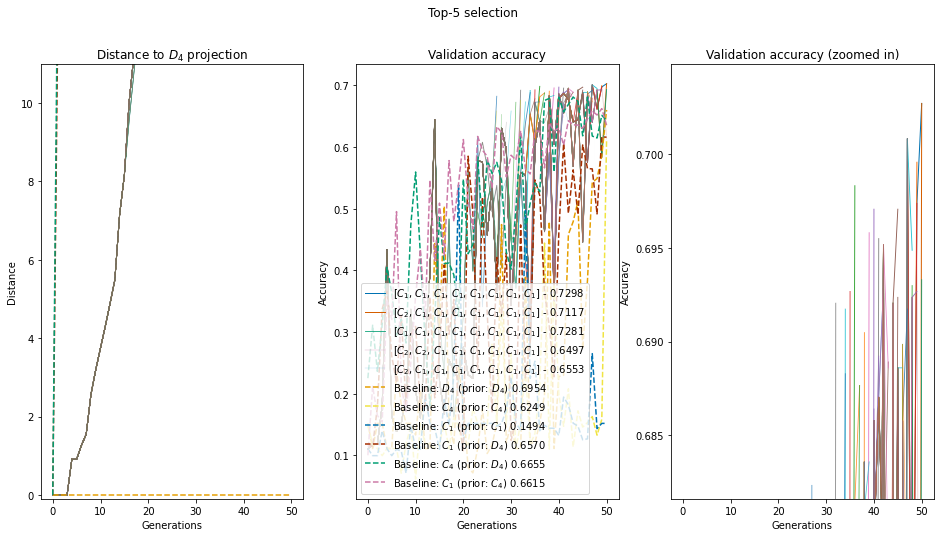

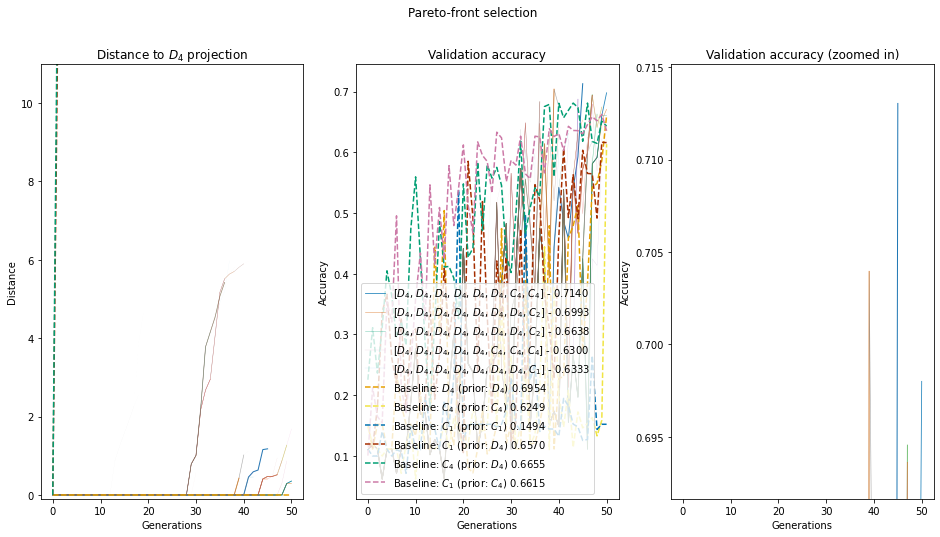

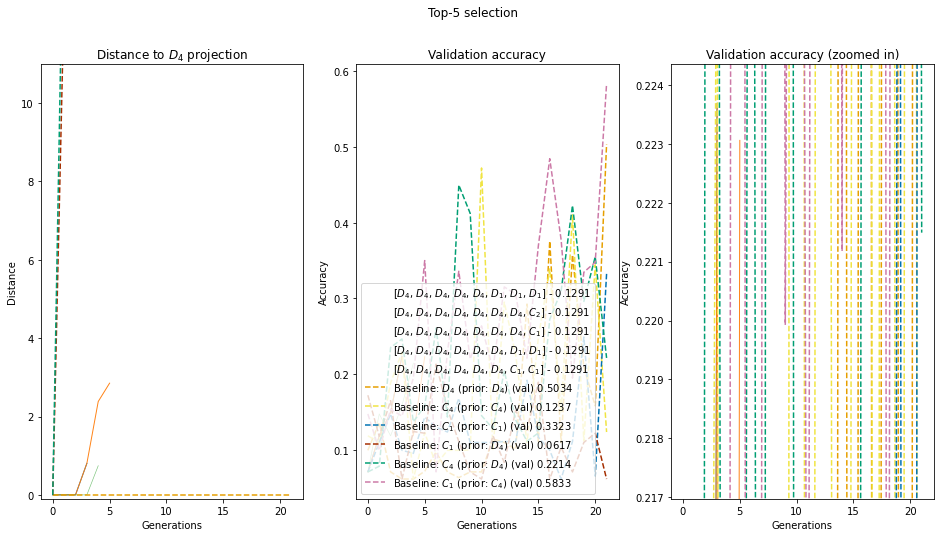

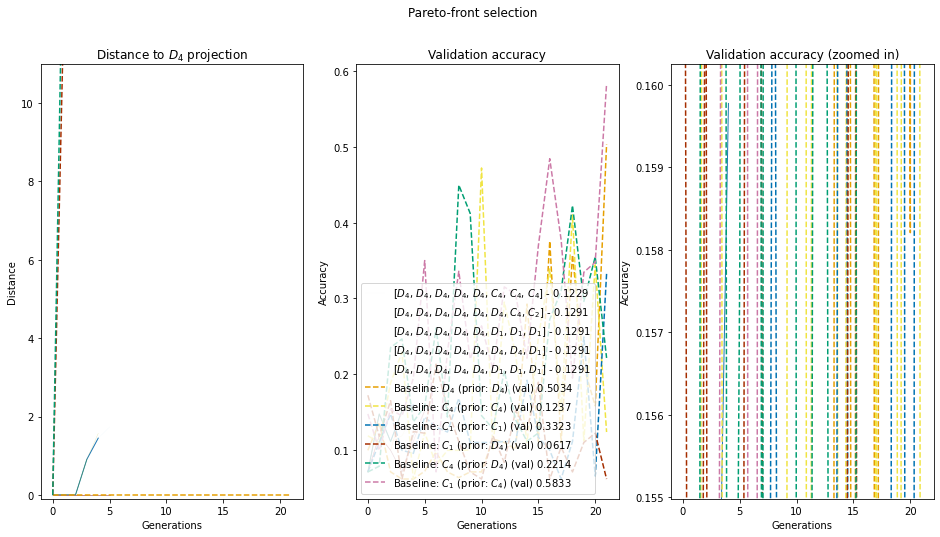

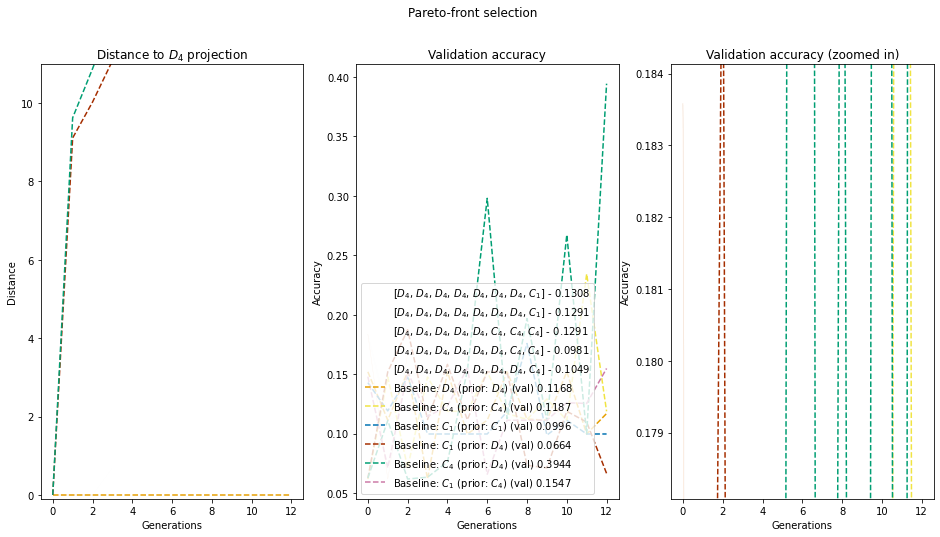

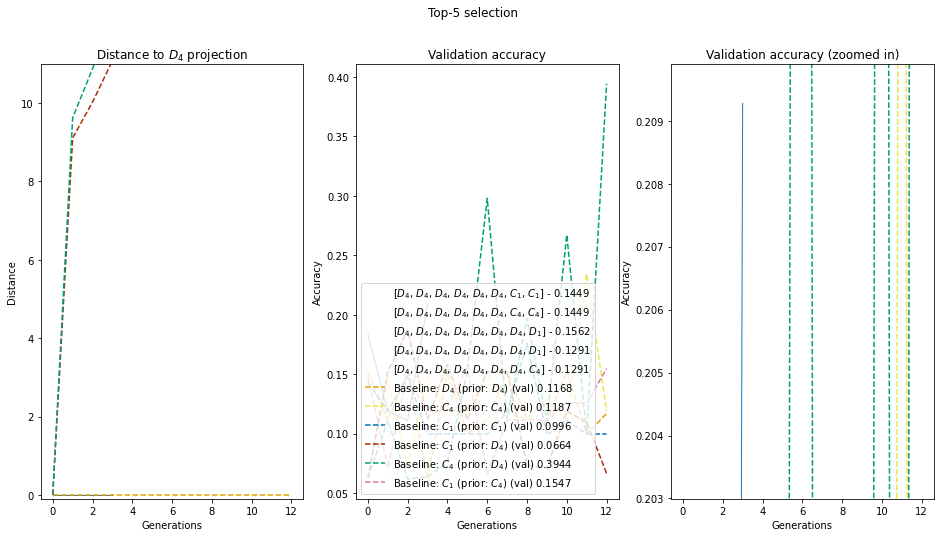

In [28]:
plothillclimb("out/lisagpu/ermnas_2022-09-22.18:49:11_galaxy10small_lr0.1_ep0.5")
plothillclimb("out/lisagpu/ermnas_2022-09-23.09:16:46_galaxy10small_lr0.1_ep0.5")
plothillclimb("out/lisagpu/ermnas_2022-09-23.09:31:11_galaxy10small_lr0.1_ep0.5")



out/olympe/ermnas_2022-09-22.08:54:02_mnist_lr0.1_ep1.0
out/olympe/ermnas_2022-09-22.08:54:02_mnist_lr0.1_ep1.0/logshc_941426.pkl
{'epochs': 1.0, 'generations': 50, 'lr': 0.1, 'popsize': 5, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'skip': False, 'pareto': True, 'pareto2': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-22.08:54:02_mnist_lr0.1_ep1.0', 'name': '941426', 'task': 'mnist', 'train_vanilla': False, 'val_vanilla': False, 'test_vanilla': False}
0.6837500333786011 0.9866666793823242
dict_keys(['epochs', 'generations', 'lr', 'popsize', 'baselines', 'data', 'd16', 'c4', 'seed', 'dea', 'skip', 'pareto', 'pareto2', 'unique', 'test', 'folder', 'name', 'task', 'train_vanilla', 'val_vanilla', 'test_vanilla'])
out/olympe/ermnas_2022-09-22.08:54:02_mnist_lr0.1_ep1.0/logshc_941425.pkl
{'epochs': 1.0, 'generations': 50, 'lr': 0.1, 'popsize': 5, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': F

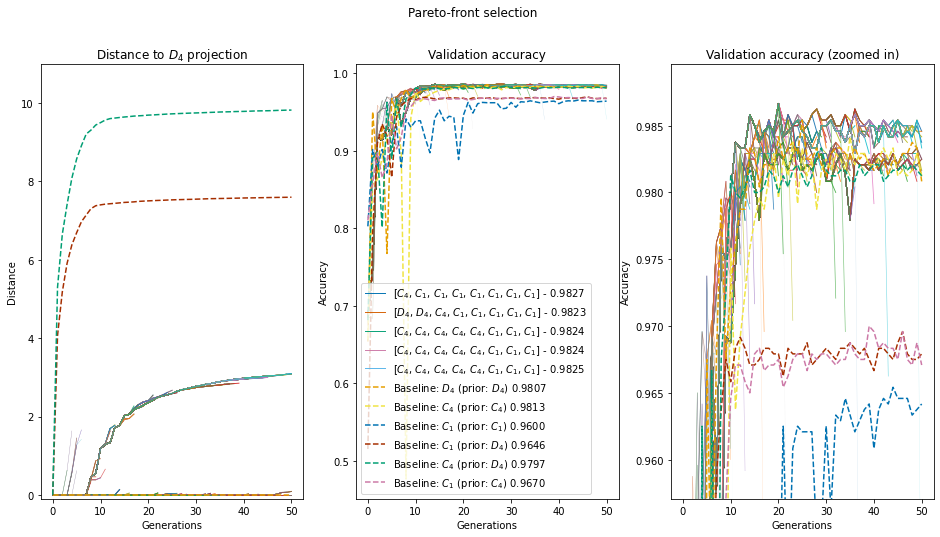

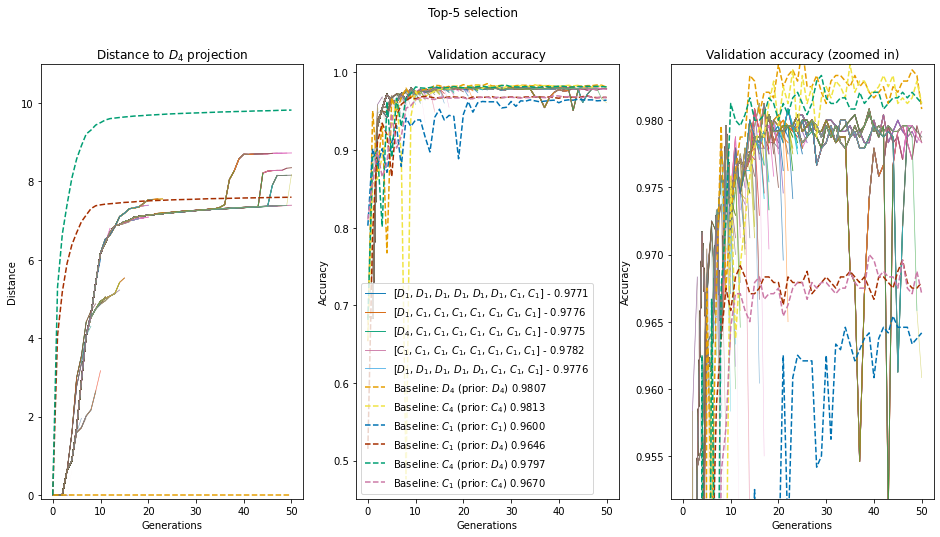

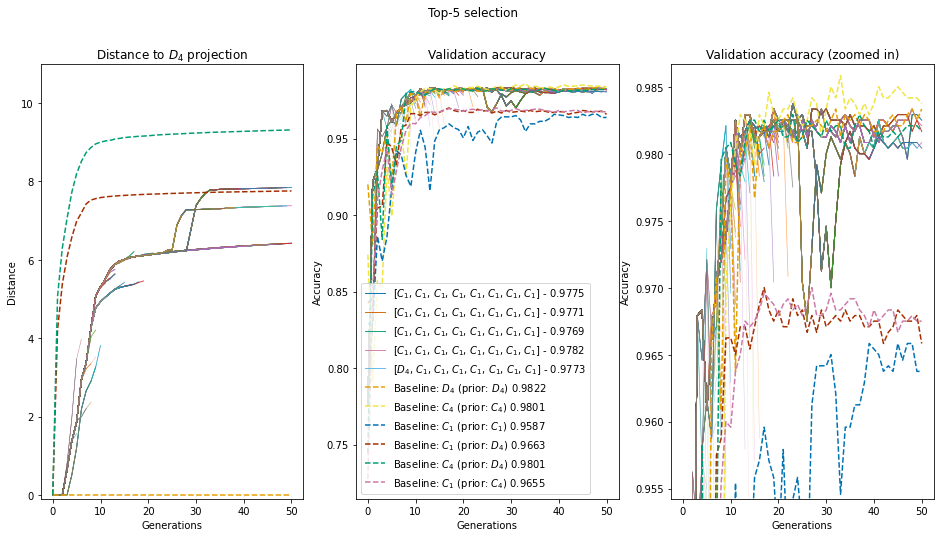

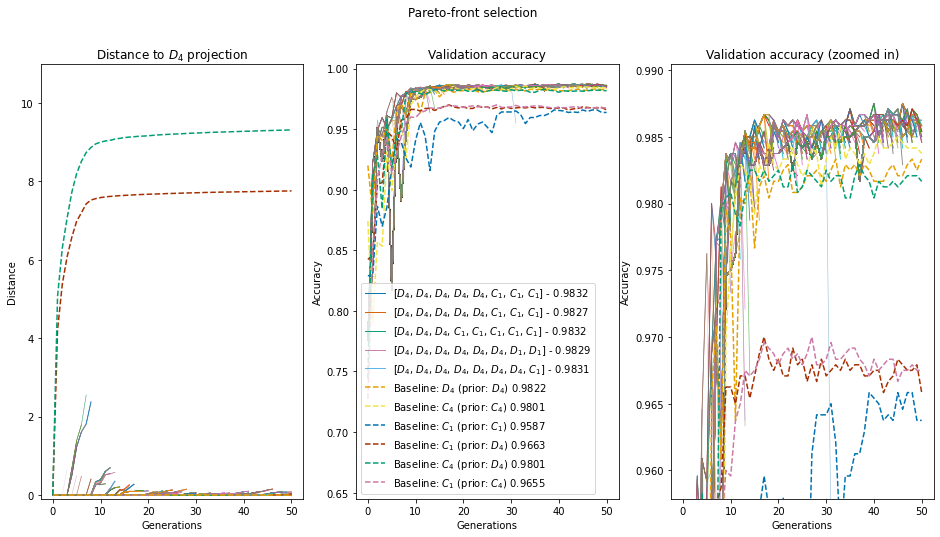

In [33]:
plothillclimb("out/olympe/ermnas_2022-09-22.08:54:02_mnist_lr0.1_ep1.0")
#plothillclimb("out/olympe/ermnas_2022-09-22.08:54:02_mnist_lr0.03_ep1.0")
plothillclimb("out/olympe/ermnas_2022-09-22.12:07:25_mnist_lr0.1_ep1.0")
#plothillclimb("out/olympe/ermnas_2022-09-22.12:07:25_mnist_lr0.03_ep1.0")
#plothillclimb("out/olympe/ermnas_2022-09-22.18:09:04_mnist_lr0.1_ep1.0")
#plothillclimb("out/olympe/ermnas_2022-09-22.18:09:04_mnist_lr0.03_ep1.0")

out/olympe/ermnas_2022-09-21.15:56:28_mnist_lr0.1_ep0.5
out/olympe/ermnas_2022-09-21.15:56:28_mnist_lr0.1_ep0.5/logshc_941117.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 5, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'skip': False, 'pareto': True, 'pareto2': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-21.15:56:28_mnist_lr0.1_ep0.5', 'name': '941117', 'task': 'mnist', 'train_vanilla': False, 'val_vanilla': False, 'test_vanilla': False}
0.46041667461395264 0.9850000143051147
dict_keys(['epochs', 'generations', 'lr', 'popsize', 'baselines', 'data', 'd16', 'c4', 'seed', 'dea', 'skip', 'pareto', 'pareto2', 'unique', 'test', 'folder', 'name', 'task', 'train_vanilla', 'val_vanilla', 'test_vanilla'])
out/olympe/ermnas_2022-09-21.15:56:28_mnist_lr0.1_ep0.5/logshc_941116.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 5, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': 

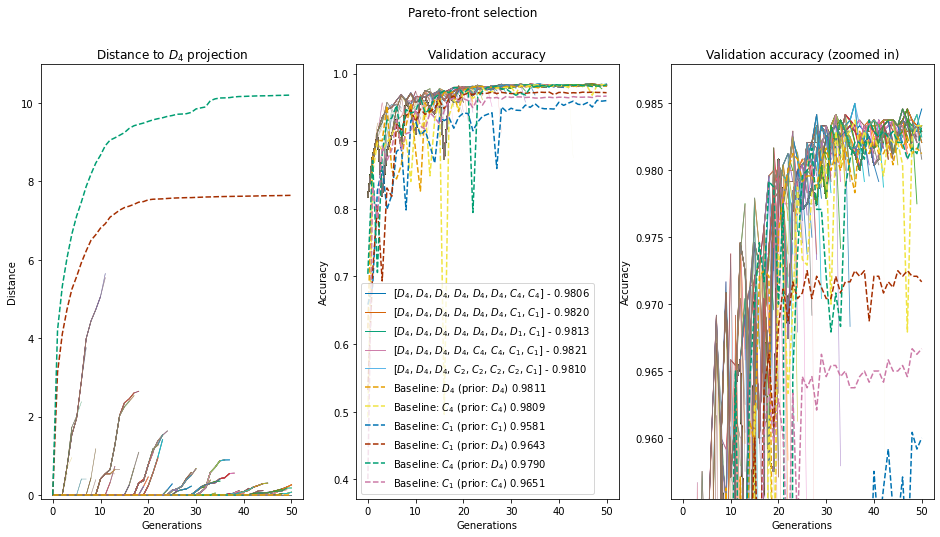

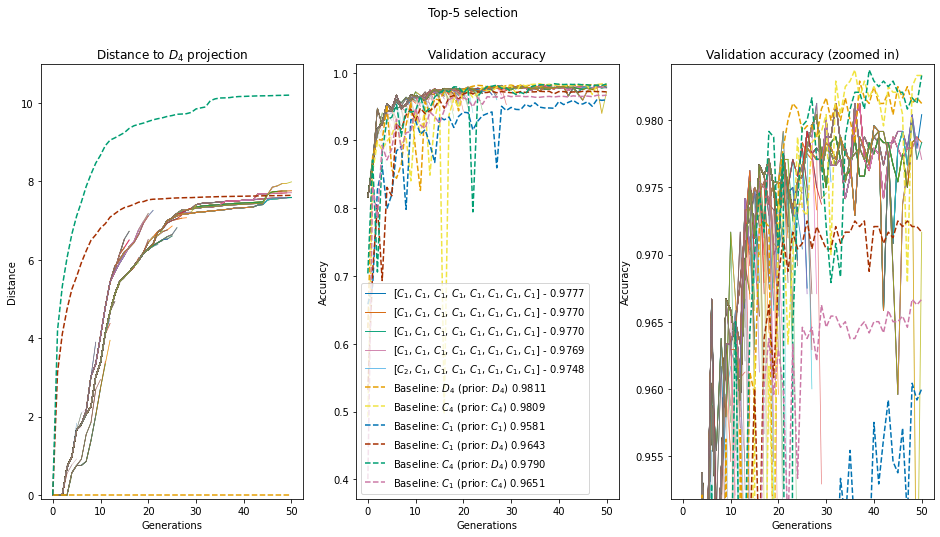

In [25]:
plothillclimb("out/olympe/ermnas_2022-09-21.15:56:28_mnist_lr0.1_ep0.5")

out/olympe/ermnas_2022-09-21.15:56:28_mnist_lr0.03_ep0.5
out/olympe/ermnas_2022-09-21.15:56:28_mnist_lr0.03_ep0.5/logshc_941113.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.03, 'popsize': 5, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'skip': False, 'pareto': False, 'pareto2': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-21.15:56:28_mnist_lr0.03_ep0.5', 'name': '941113', 'task': 'mnist', 'train_vanilla': False, 'val_vanilla': False, 'test_vanilla': False}
0.6733333468437195 0.9800000190734863
dict_keys(['epochs', 'generations', 'lr', 'popsize', 'baselines', 'data', 'd16', 'c4', 'seed', 'dea', 'skip', 'pareto', 'pareto2', 'unique', 'test', 'folder', 'name', 'task', 'train_vanilla', 'val_vanilla', 'test_vanilla'])
out/olympe/ermnas_2022-09-21.15:56:28_mnist_lr0.03_ep0.5/logshc_941114.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.03, 'popsize': 5, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), '

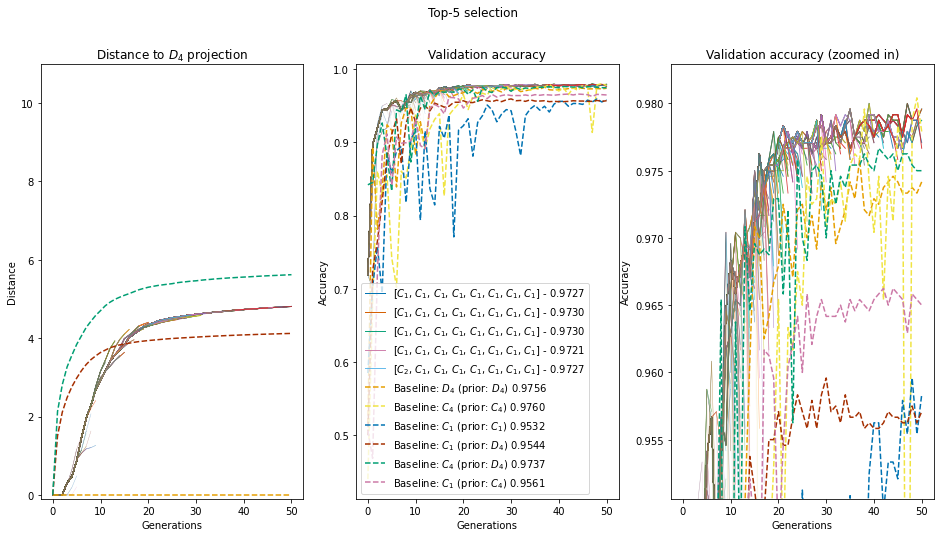

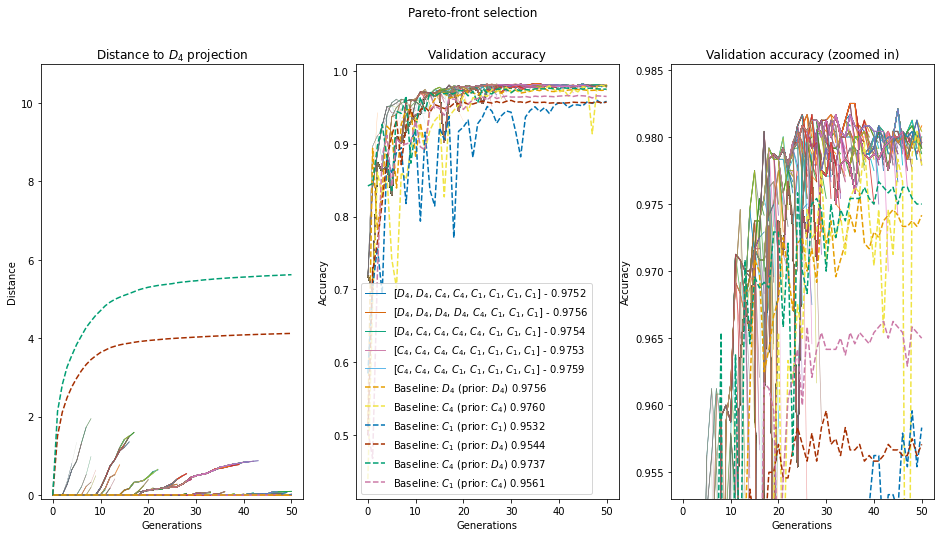

In [22]:
plothillclimb("out/olympe/ermnas_2022-09-21.15:56:28_mnist_lr0.03_ep0.5")

out/olympe/ermnas_2022-09-20.12:41:56_mnist_lr0.05_ep0.5
out/olympe/ermnas_2022-09-20.12:41:56_mnist_lr0.05_ep0.5/logshc_939636.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.05, 'popsize': 5, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': True, 'seed': 1, 'dea': True, 'skip': False, 'pareto': False, 'pareto2': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-20.12:41:56_mnist_lr0.05_ep0.5', 'name': '939636', 'task': 'mnist', 'train_vanilla': False, 'val_vanilla': False, 'test_vanilla': False}
0.518333375453949 0.9762500524520874
dict_keys(['epochs', 'generations', 'lr', 'popsize', 'baselines', 'data', 'd16', 'c4', 'seed', 'dea', 'skip', 'pareto', 'pareto2', 'unique', 'test', 'folder', 'name', 'task', 'train_vanilla', 'val_vanilla', 'test_vanilla'])
out/olympe/ermnas_2022-09-20.12:41:56_mnist_lr0.05_ep0.5/logshc_939637.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.05, 'popsize': 5, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd1

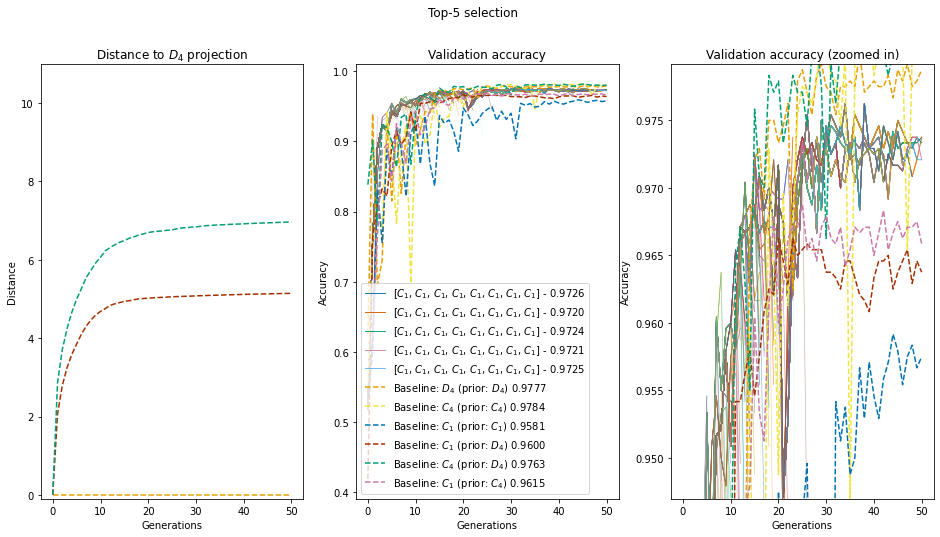

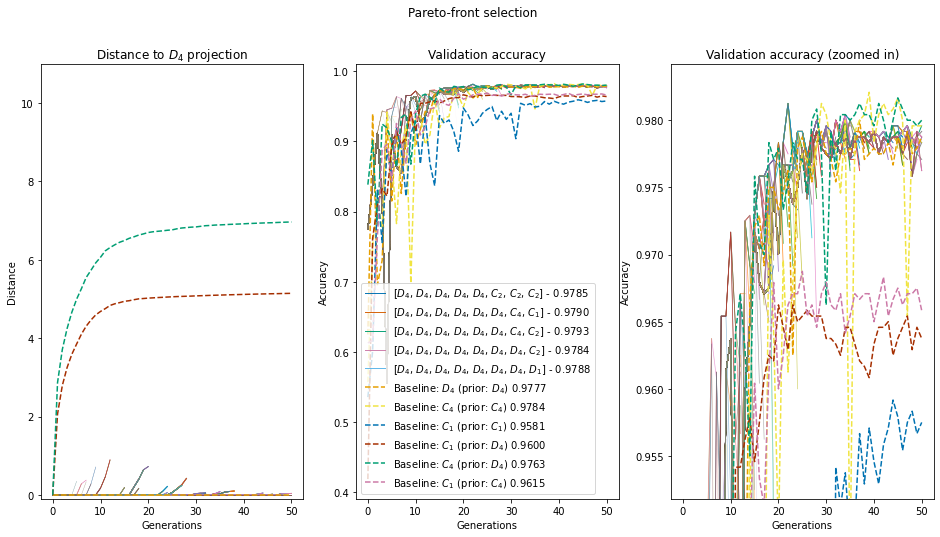

In [45]:
plothillclimb("out/olympe/ermnas_2022-09-20.12:41:56_mnist_lr0.05_ep0.5")

out/olympe/ermnas_2022-09-19.15:20:53_mnist_lr0.1_ep0.5
out/olympe/ermnas_2022-09-19.15:20:53_mnist_lr0.1_ep0.5/logshc_938792.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 5, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': True, 'pareto': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-19.15:20:53_mnist_lr0.1_ep0.5', 'name': '938792', 'task': 'mnist'}
0.46041667461395264 0.9812500476837158
dict_keys(['epochs', 'generations', 'lr', 'popsize', 'baselines', 'data', 'd16', 'c4', 'seed', 'dea', 'noskip', 'pareto', 'unique', 'test', 'folder', 'name', 'task'])
out/olympe/ermnas_2022-09-19.15:20:53_mnist_lr0.1_ep0.5/logshc_938793.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 5, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': True, 'pareto': True, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-19.15:20

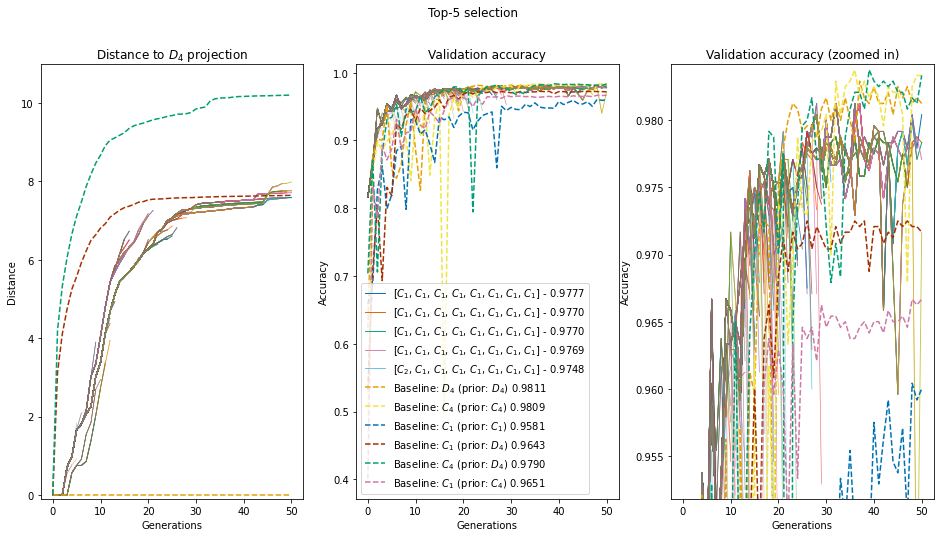

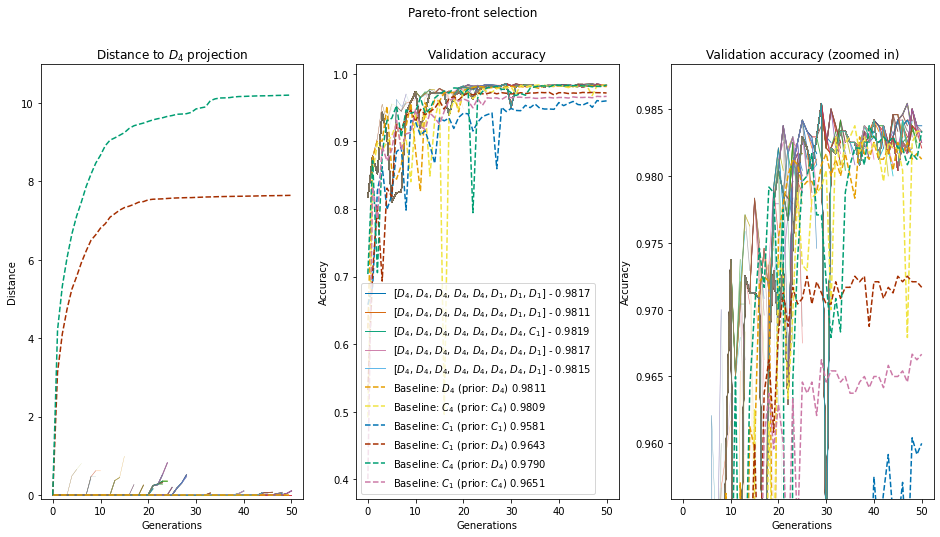

In [41]:
plothillclimb("out/olympe/ermnas_2022-09-19.15:20:53_mnist_lr0.1_ep0.5")

out/olympe/ermnas_2022-09-19.09:51:34_mnist_lr0.1_ep0.5
out/olympe/ermnas_2022-09-19.09:51:34_mnist_lr0.1_ep0.5/logshc_938133.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': True, 'pareto': True, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-19.09:51:34_mnist_lr0.1_ep0.5', 'name': '938133', 'task': 'mnist'}
0.6129167079925537 0.9858333468437195
out/olympe/ermnas_2022-09-19.09:51:34_mnist_lr0.1_ep0.5/logshc_938132.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': True, 'pareto': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-19.09:51:34_mnist_lr0.1_ep0.5', 'name': '938132', 'task': 'mnist'}
0.46041667461395264 0.9800000190734863


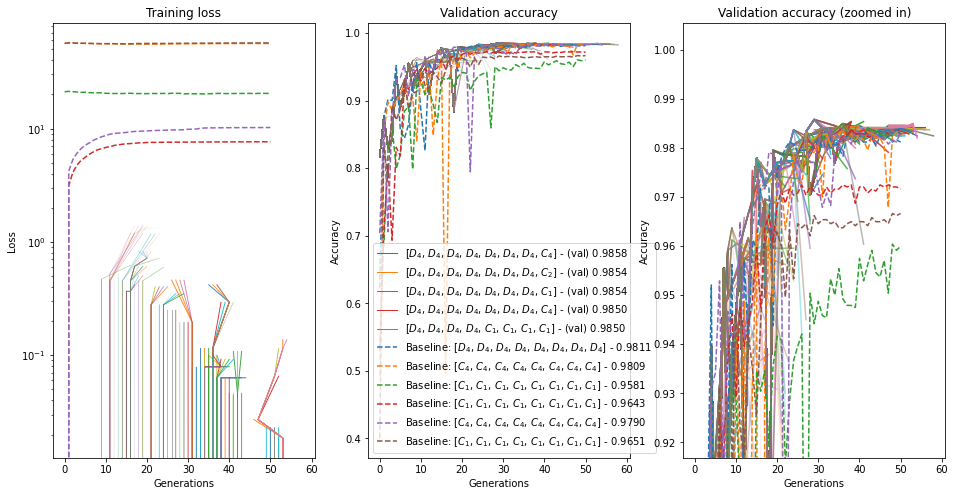

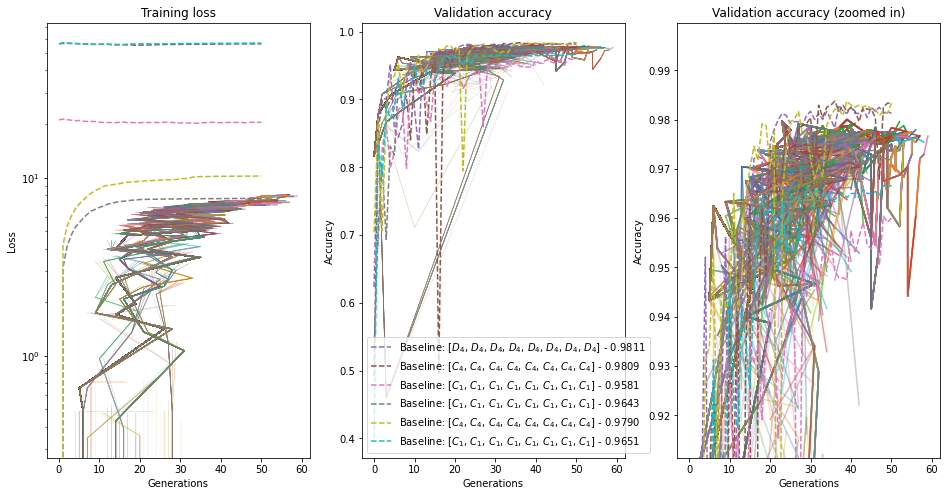

In [13]:
plothillclimb("out/olympe/ermnas_2022-09-19.09:51:34_mnist_lr0.1_ep0.5")

out/olympe/ermnas_2022-09-17.15:32:02_mnist_lr0.1_ep0.5
out/olympe/ermnas_2022-09-17.15:32:02_mnist_lr0.1_ep0.5/logshc_937733.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': True, 'pareto': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-17.15:32:02_mnist_lr0.1_ep0.5', 'name': '937733', 'task': 'mnist'}
0.46041667461395264 0.9800000190734863
out/olympe/ermnas_2022-09-17.15:32:02_mnist_lr0.1_ep0.5/logshc_937734.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': True, 'pareto': True, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-17.15:32:02_mnist_lr0.1_ep0.5', 'name': '937734', 'task': 'mnist'}
0.6129167079925537 0.9858333468437195


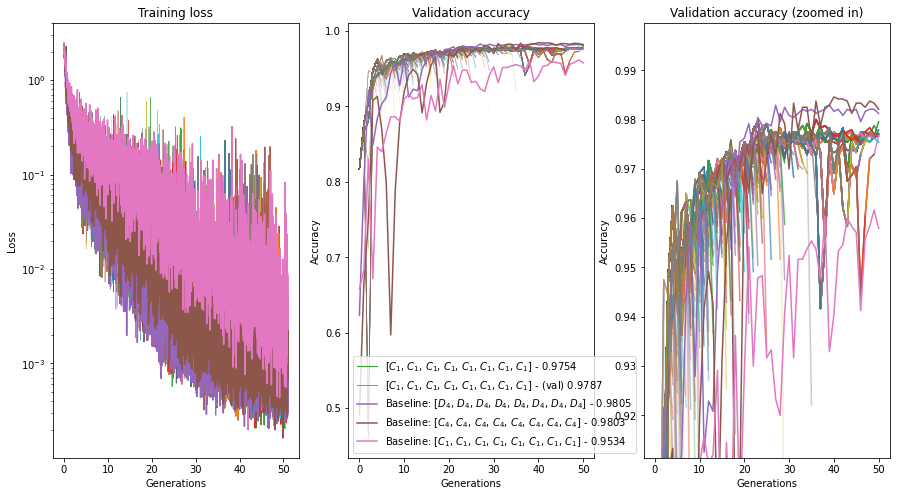

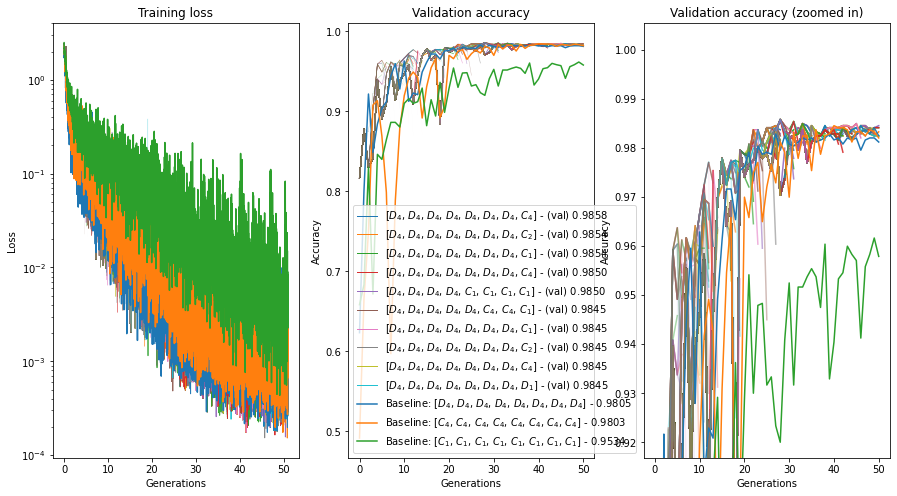

In [16]:
plothillclimb("out/olympe/ermnas_2022-09-17.15:32:02_mnist_lr0.1_ep0.5")

{'epochs': 0.2, 'generations': 100, 'lr': 0.1, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': False, 'pareto': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-15.16:21:59_mnist_lr0.1_ep0.2', 'name': '936525', 'task': 'mnist'}
0.23125000298023224 0.9695833325386047
Missing test: out/olympe/ermnas_2022-09-15.16:21:59_mnist_lr0.1_ep0.2/logshc_936525.pkl
{'epochs': 0.2, 'generations': 100, 'lr': 0.1, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': False, 'pareto': True, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-15.16:21:59_mnist_lr0.1_ep0.2', 'name': '936526', 'task': 'mnist'}
0.22625000774860382 0.9679166674613953
Missing test: out/olympe/ermnas_2022-09-15.16:21:59_mnist_lr0.1_ep0.2/logshc_936526.pkl
Missing test: out/olympe/ermnas_2022-09-15.16:21:59_mnist_lr0.1_ep0.2/logshc_936526.pkl
Mis

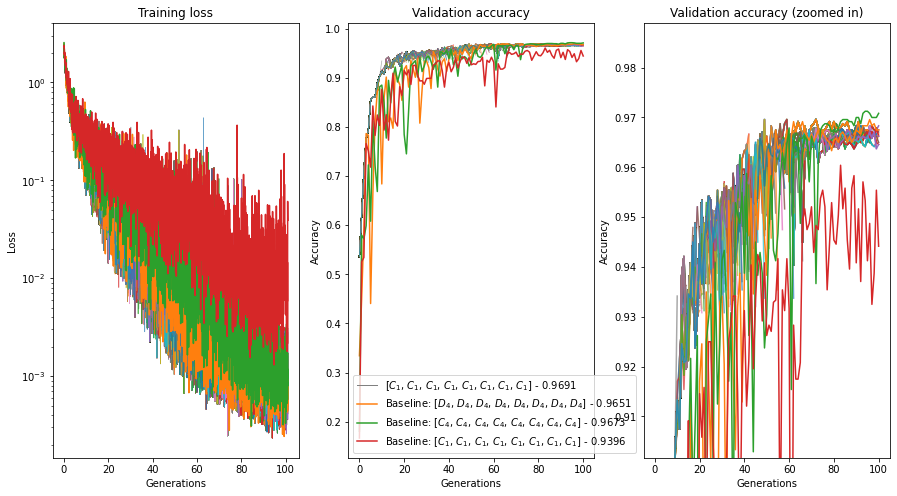

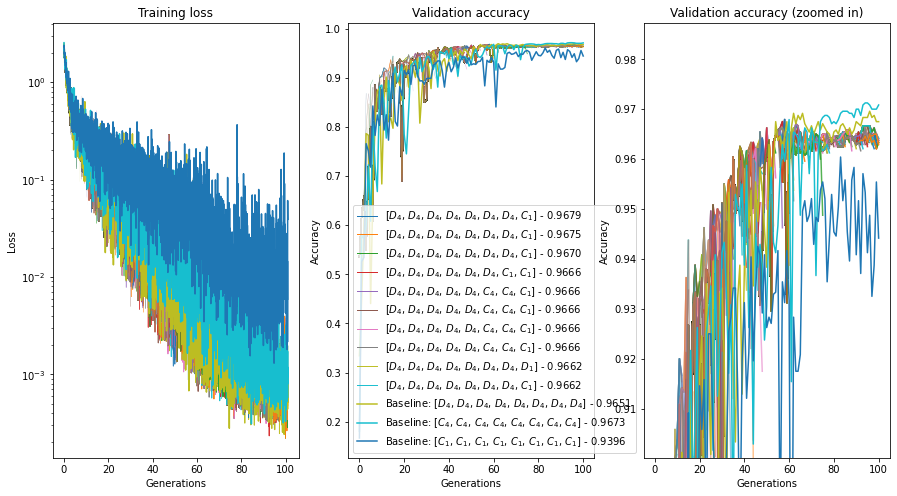

In [63]:
plothillclimb("out/olympe/ermnas_2022-09-15.16:21:59_mnist_lr0.1_ep0.2")

{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': False, 'pareto': False, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-16.08:26:40_mnist_lr0.1_ep0.5', 'name': '936736', 'task': 'mnist'}
0.49125000834465027 0.9737499952316284
Missing test: out/olympe/ermnas_2022-09-16.08:26:40_mnist_lr0.1_ep0.5/logshc_936736.pkl
{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': False, 'pareto': True, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-16.08:26:40_mnist_lr0.1_ep0.5', 'name': '936737', 'task': 'mnist'}
0.49125000834465027 0.9712499976158142
Missing test: out/olympe/ermnas_2022-09-16.08:26:40_mnist_lr0.1_ep0.5/logshc_936737.pkl
Missing test: out/olympe/ermnas_2022-09-16.08:26:40_mnist_lr0.1_ep0.5/logshc_936737.pkl
Missi

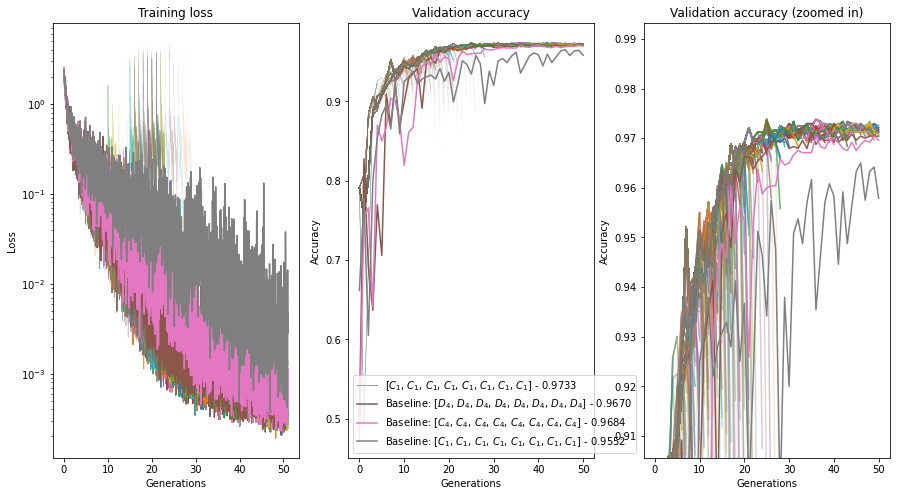

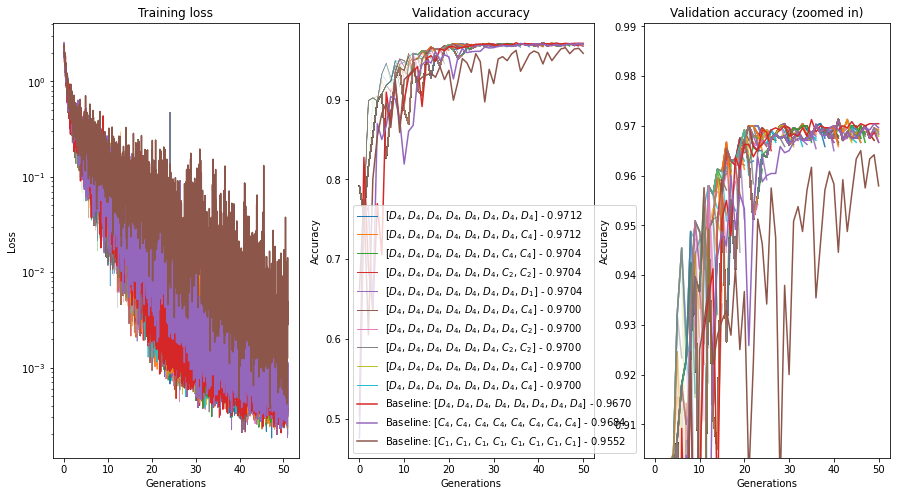

In [73]:
plothillclimb("out/olympe/ermnas_2022-09-16.08:26:40_mnist_lr0.1_ep0.5")

{'epochs': 0.5, 'generations': 100, 'lr': 0.1, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': False, 'pareto': True, 'test': True, 'folder': '/ermnas_2022-09-14.16:09:05_mnist_lr0.1_ep0.5', 'name': '935959', 'task': 'mnist'}
0.49125000834465027 0.9712499976158142
Missing test: out/olympe/ermnas_2022-09-14.16:09:05_mnist_lr0.1_ep0.5/logshc_935959.pkl
Missing test: out/olympe/ermnas_2022-09-14.16:09:05_mnist_lr0.1_ep0.5/logshc_935959.pkl
Missing test: out/olympe/ermnas_2022-09-14.16:09:05_mnist_lr0.1_ep0.5/logshc_935959.pkl
Missing test: out/olympe/ermnas_2022-09-14.16:09:05_mnist_lr0.1_ep0.5/logshc_935959.pkl
Missing test: out/olympe/ermnas_2022-09-14.16:09:05_mnist_lr0.1_ep0.5/logshc_935959.pkl
Missing test: out/olympe/ermnas_2022-09-14.16:09:05_mnist_lr0.1_ep0.5/logshc_935959.pkl
Missing test: out/olympe/ermnas_2022-09-14.16:09:05_mnist_lr0.1_ep0.5/logshc_935959.pkl
Missing test: out

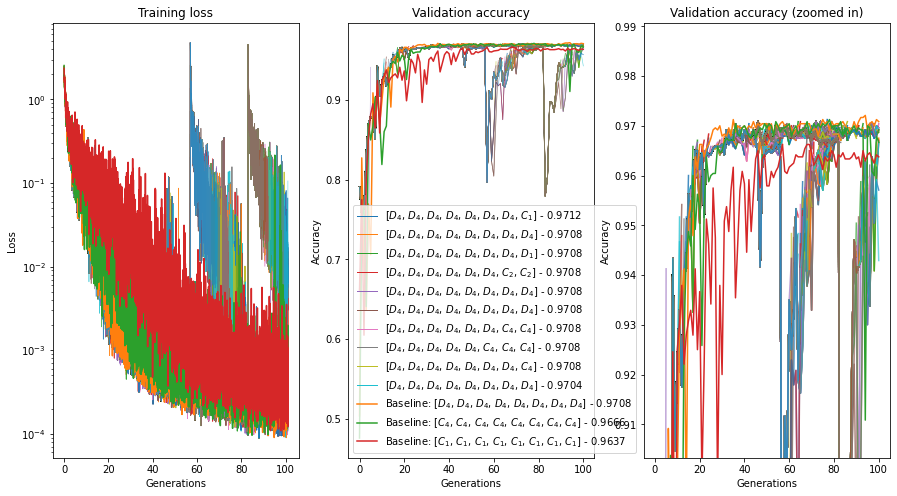

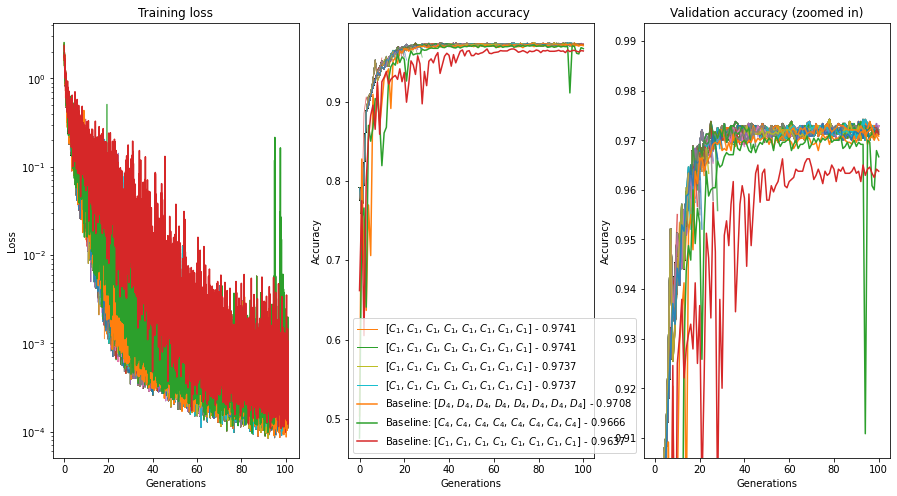

In [65]:
plothillclimb("out/olympe/ermnas_2022-09-14.16:09:05_mnist_lr0.1_ep0.5")

{'epochs': 0.2, 'iterations': 50, 'lr': 0.03, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': -1, 'dea': True, 'noskip': False, 'pareto': True, 'test': False, 'folder': ''}
0.2904166877269745 0.9600000381469727
Missing test: out/olympe/logshc_2022-09-13_16:52:16.pkl
Missing test: out/olympe/logshc_2022-09-13_16:52:16.pkl
Missing test: out/olympe/logshc_2022-09-13_16:52:16.pkl
Missing test: out/olympe/logshc_2022-09-13_16:52:16.pkl
Missing test: out/olympe/logshc_2022-09-13_16:52:16.pkl
Missing test: out/olympe/logshc_2022-09-13_16:52:16.pkl
Missing test: out/olympe/logshc_2022-09-13_16:52:16.pkl
Missing test: out/olympe/logshc_2022-09-13_16:52:16.pkl
Missing test: out/olympe/logshc_2022-09-13_16:52:16.pkl
Missing test: out/olympe/logshc_2022-09-13_16:52:16.pkl
Missing test: out/olympe/logsbs_2022-09-13_16:52:20.pkl
Missing test: out/olympe/logsbs_2022-09-13_16:52:20.pkl
Missing test: out/olympe/logsbs_2022-09-1

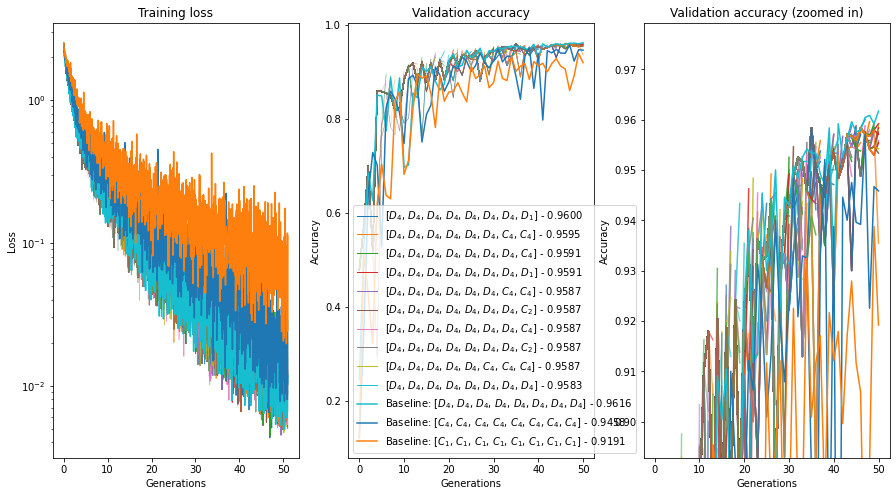

In [66]:
plothillclimb("out/olympe/logshc_2022-09-13_16:52:16.pkl","out/olympe/logsbs_2022-09-13_16:52:20.pkl")

{'epochs': 0.5, 'generations': 50, 'lr': 0.1, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': True, 'pareto': True, 'unique': False, 'test': True, 'folder': '/ermnas_2022-09-16.08:28:02_mnist_lr0.1_ep0.5', 'name': '936740', 'task': 'mnist'}
0.4079166650772095 0.9708333611488342
Missing test: out/olympe/ermnas_2022-09-16.08:28:02_mnist_lr0.1_ep0.5/logshc_936740.pkl
Missing test: out/olympe/ermnas_2022-09-16.08:28:02_mnist_lr0.1_ep0.5/logshc_936740.pkl
Missing test: out/olympe/ermnas_2022-09-16.08:28:02_mnist_lr0.1_ep0.5/logshc_936740.pkl
Missing test: out/olympe/ermnas_2022-09-16.08:28:02_mnist_lr0.1_ep0.5/logshc_936740.pkl
Missing test: out/olympe/ermnas_2022-09-16.08:28:02_mnist_lr0.1_ep0.5/logshc_936740.pkl
Missing test: out/olympe/ermnas_2022-09-16.08:28:02_mnist_lr0.1_ep0.5/logshc_936740.pkl
Missing test: out/olympe/ermnas_2022-09-16.08:28:02_mnist_lr0.1_ep0.5/logshc_936740.pkl
Missing test: out/oly

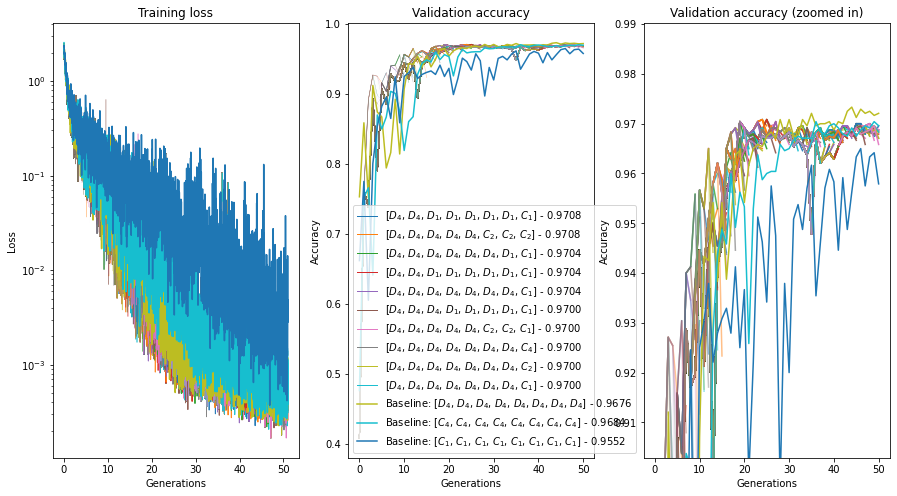

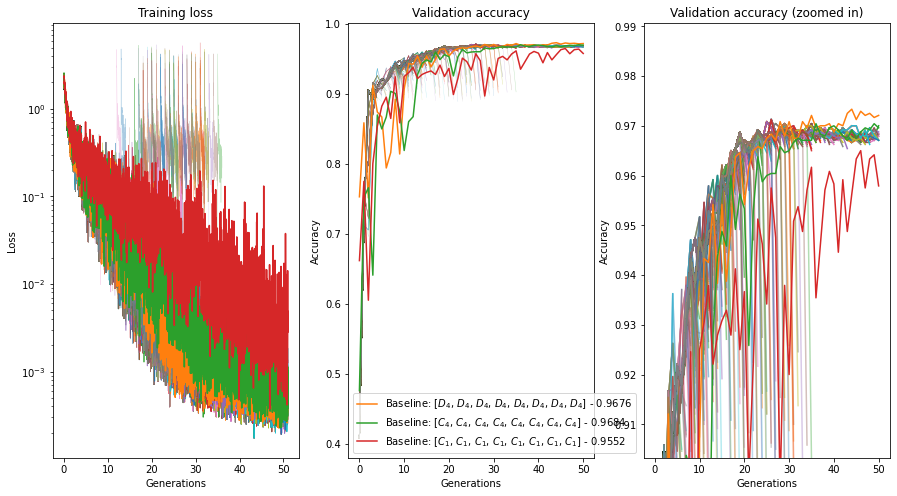

In [74]:
plothillclimb("out/olympe/ermnas_2022-09-16.08:28:02_mnist_lr0.1_ep0.5")

{'epochs': 1, 'iterations': 50, 'lr': 0.1, 'allkids': False, 'popsize': 10, 'baselines': False, 'reg': False, 'skip': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': True, 'seed': -1, 'dea': True}
0.48500001430511475 0.9750000238418579
Missing test: out/olympe/logshc_2022-09-06_15:52:35.pkl


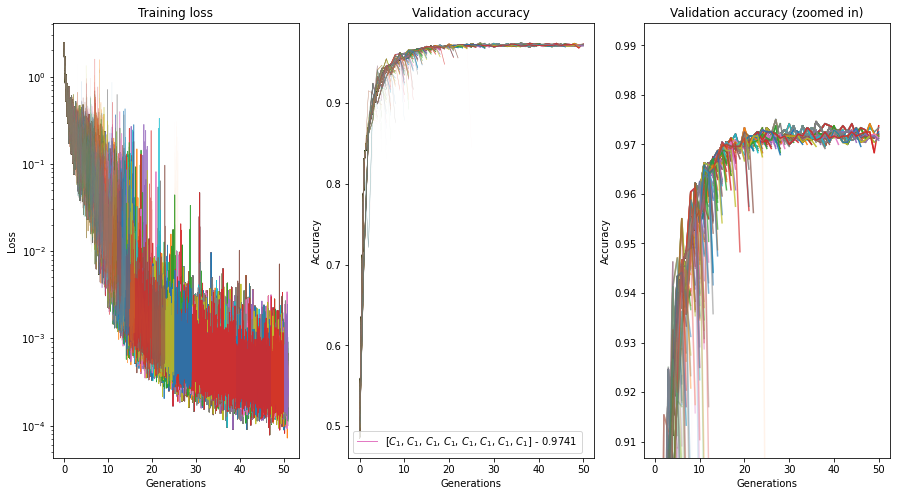

In [68]:
plothillclimb("out/olympe/logshc_2022-09-06_15:52:35.pkl")

{'epochs': 0.5, 'iterations': 50, 'lr': 0.05, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': False, 'pareto': False, 'test': False, 'folder': '/ermnas_mnist_lr_ep_2022-09-14.10:04:22', 'task': 'mnist'}
0.6462500095367432 0.9679166674613953
Missing test: out/olympe/ermnas_mnist_lr_ep_2022-09-14.10:04:22/logsbs_2022-09-14_10:04:24.pkl
Missing test: out/olympe/ermnas_mnist_lr_ep_2022-09-14.10:04:22/logsbs_2022-09-14_10:04:24.pkl
Missing test: out/olympe/ermnas_mnist_lr_ep_2022-09-14.10:04:22/logsbs_2022-09-14_10:04:24.pkl


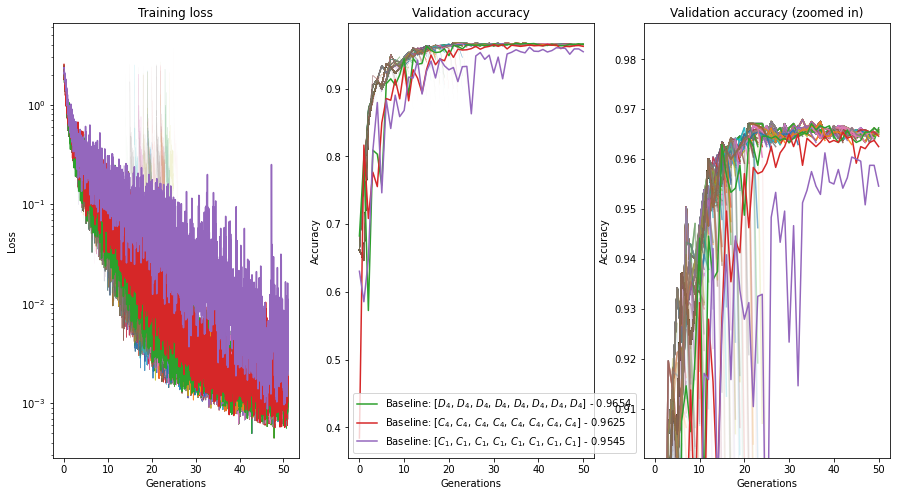

In [69]:
plothillclimb("out/olympe/ermnas_mnist_lr_ep_2022-09-14.10:04:22")

{'epochs': 0.5, 'generations': 100, 'lr': 0.05, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': 1, 'dea': True, 'noskip': False, 'pareto': False, 'test': False, 'folder': '/ermnas_mnist_lr_ep_2022-09-14.10:20:42', 'task': 'mnist'}
0.6462500095367432 0.9679166674613953
Missing test: out/olympe/ermnas_mnist_lr_ep_2022-09-14.10:20:42/logsbs_2022-09-14_11:07:41.pkl
Missing test: out/olympe/ermnas_mnist_lr_ep_2022-09-14.10:20:42/logsbs_2022-09-14_11:07:41.pkl
Missing test: out/olympe/ermnas_mnist_lr_ep_2022-09-14.10:20:42/logsbs_2022-09-14_11:07:41.pkl


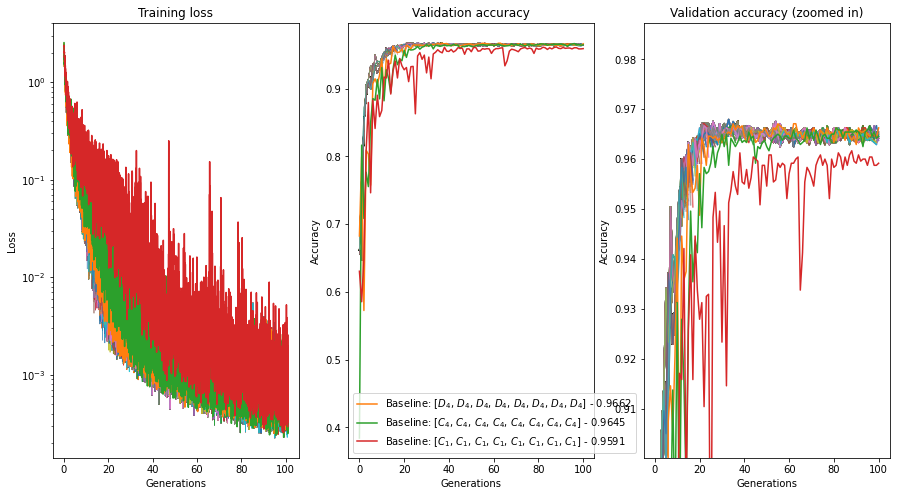

In [70]:
plothillclimb("out/olympe/ermnas_mnist_lr_ep_2022-09-14.10:20:42")

{'epochs': 1.0, 'iterations': 50, 'lr': 0.1, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': -1, 'dea': True}
0.6008333563804626 0.9737499952316284


No handles with labels found to put in legend.


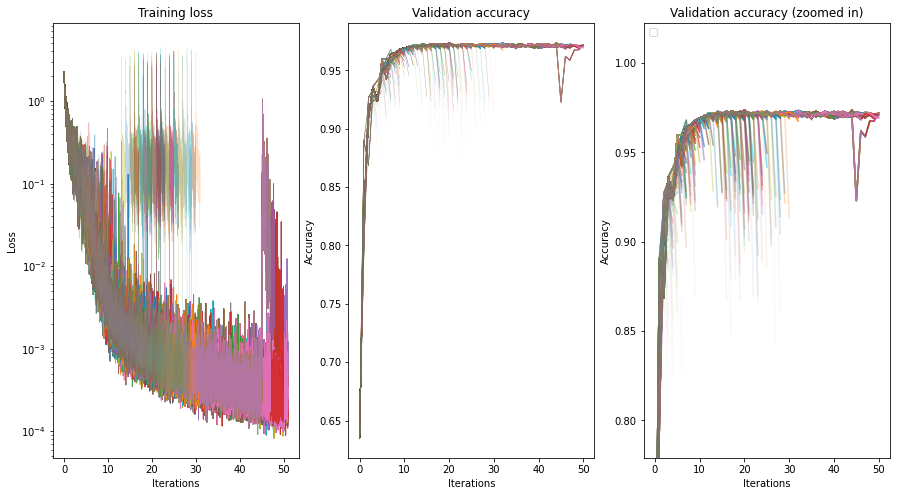

In [ ]:
plothillclimb("out/olympe/logshc_2022-09-09_14:20:04.pkl")

{'epochs': 0.5, 'iterations': 50, 'lr': 0.03, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': True, 'seed': -1, 'dea': True}
0.5912500023841858 0.9633333683013916


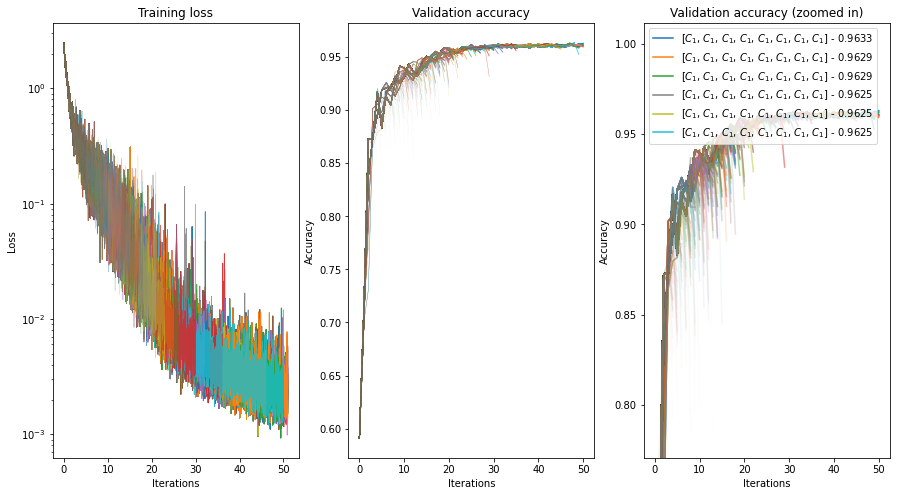

In [ ]:
plothillclimb("out/olympe/logshc_2022-09-09_14:22:08.pkl")

{'epochs': 0.5, 'iterations': 50, 'lr': 0.1, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': -1, 'dea': True}
0.2604166865348816 0.9762500524520874
Missing test: out/olympe/logshc_2022-09-09_16:37:30.pkl
Missing test: out/olympe/logshc_2022-09-09_16:37:30.pkl
Missing test: out/olympe/logshc_2022-09-09_16:37:30.pkl


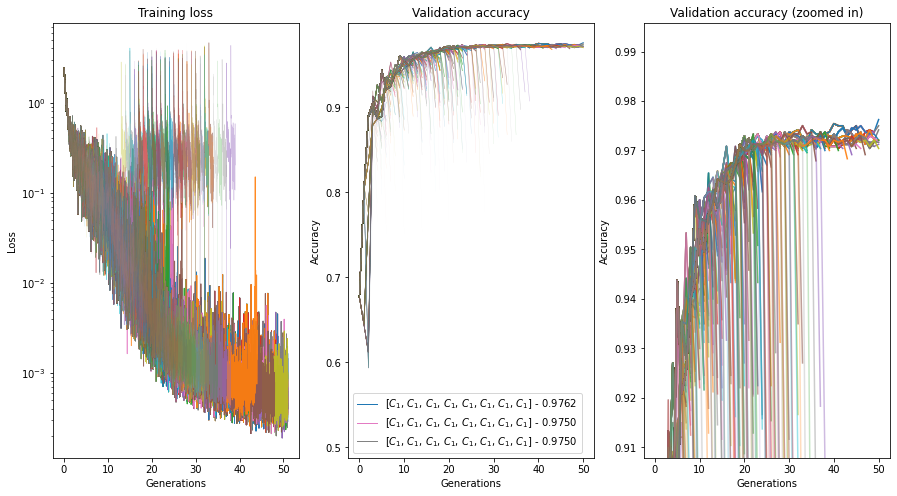

In [71]:
plothillclimb("out/olympe/logshc_2022-09-09_16:37:30.pkl")

{'epochs': 0.5, 'iterations': 50, 'lr': 0.1, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': -1, 'dea': True}
0.2604166865348816 0.9762500524520874


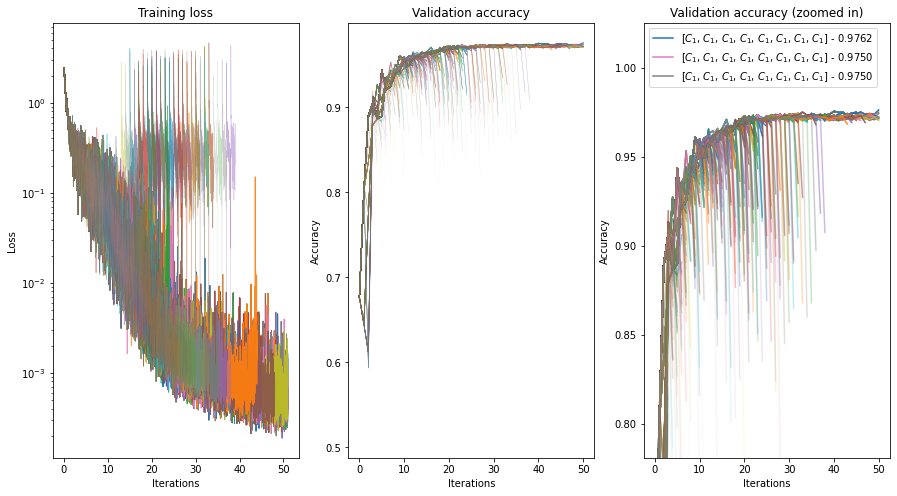

In [3]:
plothillclimb("out/olympe/logshc_2022-09-09_16:37:30.pkl")

{'epochs': 0.2, 'iterations': 50, 'lr': 0.1, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': -1, 'dea': True}
0.2162500023841858 0.9704166650772095
Missing test: out/olympe/logshc_2022-09-09_16:53:27.pkl
Missing test: out/olympe/logshc_2022-09-09_16:53:27.pkl
Missing test: out/olympe/logshc_2022-09-09_16:53:27.pkl
Missing test: out/olympe/logshc_2022-09-09_16:53:27.pkl
Missing test: out/olympe/logshc_2022-09-09_16:53:27.pkl
Missing test: out/olympe/logshc_2022-09-09_16:53:27.pkl
Missing test: out/olympe/logshc_2022-09-09_16:53:27.pkl
Missing test: out/olympe/logshc_2022-09-09_16:53:27.pkl


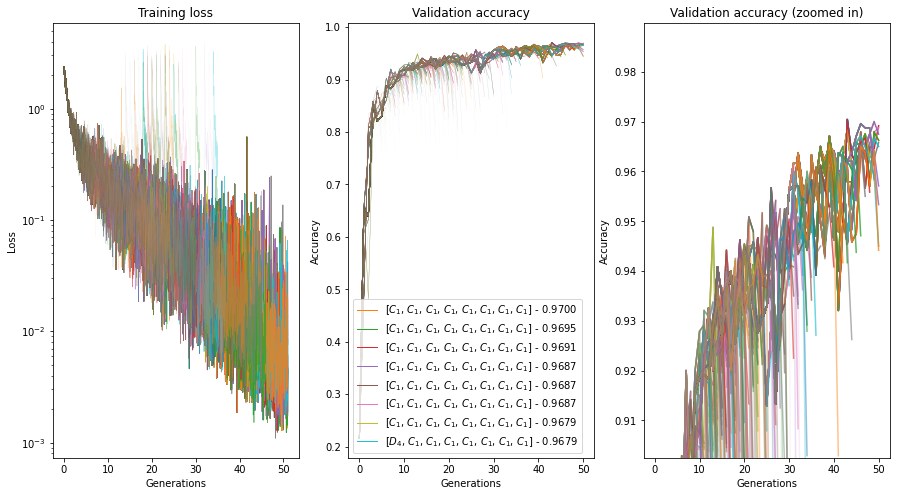

In [72]:
plothillclimb("out/olympe/logshc_2022-09-09_16:53:27.pkl")

{'epochs': 0.2, 'iterations': 50, 'lr': 0.03, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': True, 'seed': -1, 'dea': True}
0.25874999165534973 0.965416669845581


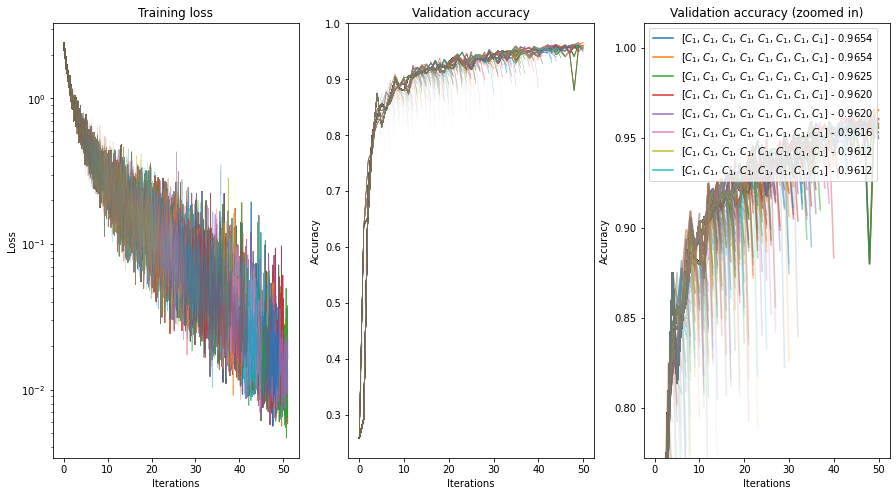

In [ ]:
plothillclimb("out/olympe/logshc_2022-09-09_17:52:37.pkl")

{'epochs': 0.2, 'iterations': 50, 'lr': 0.03, 'allkids': False, 'popsize': 10, 'baselines': False, 'data': PosixPath('/tmpdir/maile'), 'd16': False, 'c4': False, 'seed': -1, 'dea': True, 'pareto': False}
0.25208333134651184 0.9641667008399963


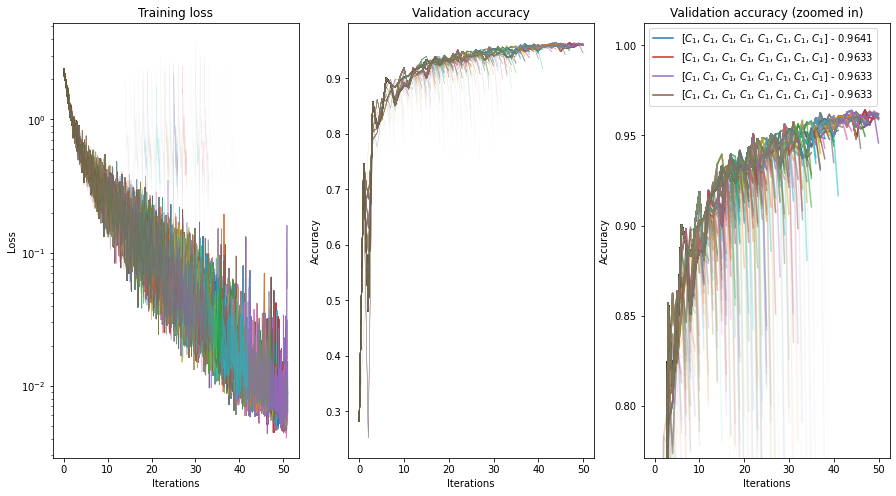

In [4]:
plothillclimb("out/olympe/logshc_2022-09-13_13:46:05.pkl")